### Multi Modal Data with LLms

- using unstructured
- Generate text summary for images
- using image summary embeddings and text embeddings pairs in the VectorDB

In [1]:
# %pip install unstructured==0.16.6 
# %pip install pdfminer.six 
# %pip install pillow 
# %pip install pi_heif
# %pip install unstructured_inference 
# %pip install poppler-utils
# %pip install pdf2image
# %conda install -c conda-forge poppler  --y
# %pip install unstructured_pytesseract 
# %conda install -c conda-forge tesseract --y

### Importing the required components

In [2]:
# %pip install --upgrade opencv-python opencv-python-headless
# %pip install --upgrade layoutparser

In [3]:
from unstructured.partition.pdf import partition_pdf

### Parsing the PDF

In [14]:
file_path = 'data/Attention.pdf'

chunks = partition_pdf(
    filename =file_path,
    infer_table_structure=True,
    strategy="hi_res",
    extract_image_block_types=["Image", "Table"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_char=6000
)

In [15]:
print(chunks[:2])

[<unstructured.documents.elements.CompositeElement object at 0x368019ee0>, <unstructured.documents.elements.CompositeElement object at 0x3649c4670>]


In [16]:
from IPython.display import Markdown, display

display(Markdown(str(chunks[2].text)))

3 Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure [5] [2] 35). Here, the encoder maps an input sequence of symbol representations (21, ...,%,,) to a sequence of continuous representations z = (z1,...,2n). Given z, the decoder then generates an output sequence (yj, ..., Ym) of symbols one element at a time. At each step the model is auto-regressive , consuming the previously generated symbols as additional input when generating the next.

Output

Probabilities Linear Add & Norm Feed Forward Add & Norm Multi-Head Attention Add & Norm Nx Masked Multi-Head Multi-Head Attention Attention Se a, ee a, Positional Positional Encoding @ © @ Encoding Input Output Embedding Embedding Inputs Outputs (shifted right)

Figure 1: The Transformer - model architecture.

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure[I] respectively.

3.1 Encoder and Decoder Stacks

Encoder: The encoder is composed of a stack of N = 6 identical layers. Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position- wise fully connected feed-forward network. We employ a residual connection around each of the two sub-layers, followed by layer normalization [I]. That is, the output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer() is the function implemented by the sub-layer itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension dmode = 512.

Decoder: The decoder is also composed of a stack of N = 6 identical layers. In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization. We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than 7.

In [17]:
chunks[2].metadata.orig_elements

-- We got the metadata for the image, Title, and text

In [18]:
from IPython.display import Markdown, display,HTML
display(HTML(chunks[6].metadata.text_as_html))

Layer Type,Complexity per Layer,Sequential Operations,Maximum Path Length
Self-Attention,O(n? - d),O(1),O(1)
Recurrent,O(n- d?),O(n),O(n)
Convolutional,O(k-n-d?),O(1),O(logy(n))
Self-Attention (restricted),O(r-n-d),ol),O(n/r)


### Separate images, texts and tables

In [19]:
chunks

In [20]:
import unstructured

texts, tables, images = [], [], []

for chunk in chunks:
    if isinstance(chunk, unstructured.documents.elements.Table):
        tables.append(chunk)
    elif isinstance(chunk, unstructured.documents.elements.CompositeElement):
        texts.append(chunk)

        chunk_elements = chunk.metadata.orig_elements

        # iterate over all elements of this chunk
        for element in chunk_elements:
            if isinstance(element, unstructured.documents.elements.Image):
                images.append(element.metadata.image_base64)

In [21]:
print(f"Total Texts:", len(texts))
print(f"Total Tables:", len(tables))
print(f"Total Images:", len(images))

Total Texts: 13
Total Tables: 4
Total Images: 6


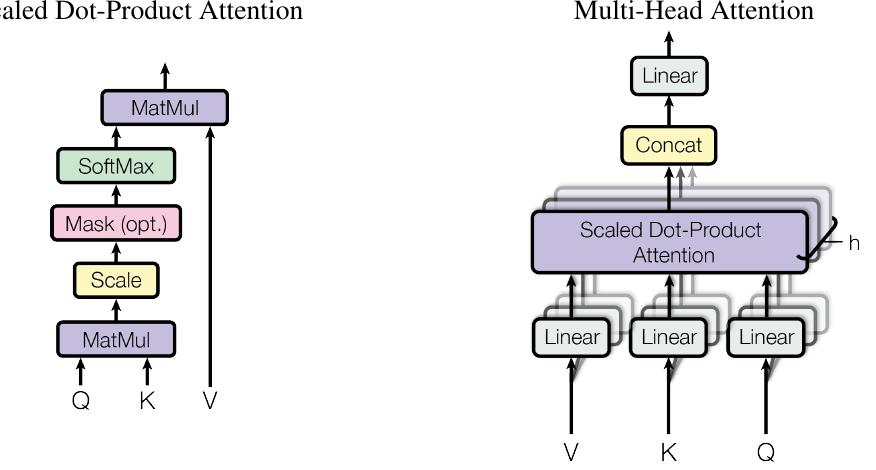

In [22]:
import base64
from IPython.display import Image,display

image_data = base64.b64decode(images[1])
display(Image(data=image_data))

In [23]:
## Storing the abovek images as local files before we can pass them to the multimodal LLM

import base64
from IPython.display import Image,display

for idx, image in enumerate(images):
    
    image_data = base64.b64decode(image)

    path = f"data/image_{idx}.jpeg"

    with open(path, "wb") as f:
        f.write(image_data)

### Summarize images, texts and tables

In [24]:
## summarize images

import ollama

def get_image_summary(file_path):
    
    response = ollama.chat(
        model = 'llama3.2-vision',
        messages=[{
            'role': 'user',
            'content': 'Summarize this , for better redability and mathematical representation',
            'iamges': [file_path]
        }]
    )
    return response.message_content


In [25]:
from tqdm import tqdm

In [ ]:

image_summaries = [get_image_summary(f"image_{i+1}.jpeg") \
                   for i in tqdm(range(len(images)))]

In [ ]:
import pickle
with open("static/image_summaries.pkl", "wb") as f:
    pickle.dump(image_summaries, f)

In [27]:
import pickle
with open("static/image_summaries.pkl", "rb") as f:
    image_summaries = pickle.load(f)

In [28]:
from IPython.display import Markdown, display
display(Markdown(image_summaries[1]))

**Overview of the Image**

The image presents a detailed illustration of two types of attention mechanisms: **Scaled Dot-Product Attention** and **Multi-Head Attention**. These concepts are central to various applications in machine learning, particularly in transformer models.

**Scaled Dot-Product Attention**

This section illustrates the scaled dot-product attention mechanism. It consists of three primary components:

*   **Query (Q)**: The input vector that represents the information being queried.
*   **Key (K)**: The input vector that represents the information relevant to the query.
*   **Value (V)**: The input vector that provides additional context or relevance.

The scaled dot-product attention mechanism calculates the similarity between the query and key vectors, then scales this similarity by a factor of 1/sqrt(d), where d is the dimensionality of the vectors. This scaling helps prevent the dot product from growing too large as the sequence length increases. The final output is obtained by taking the weighted sum of the value vectors based on their attention scores.

**Multi-Head Attention**

This section demonstrates the multi-head attention mechanism, which is a key component of transformer models. It involves applying multiple instances of scaled dot-product attention in parallel to different subsets of the input sequence. Each head attends to different aspects of the input and combines these attentions through concatenation or averaging.

The benefits of multi-head attention include:

*   **Improved Representation Learning**: By attending to different aspects of the input, each head can capture distinct information, leading to more comprehensive representations.
*   **Robustness and Generalization**: The combination of multiple heads enhances model robustness against various tasks and improves generalizability.

**Key Takeaways**

The image effectively illustrates the inner workings of two critical attention mechanisms in deep learning. Understanding these concepts is essential for developing effective transformer models that can handle complex natural language processing tasks with high accuracy and efficiency.

In [29]:
## summarize text

def get_text_summary(text):

    response = ollama.chat(
        model = 'llama3.2:1b',
        messages = [{
            'role': 'user',
            'content': f'Summarize this text: {text}'
        }]
    )
    return response.message.content

text_summaries = [get_text_summary(texts[i].text) \
                  for i in tqdm(range(len(texts)))]

100%|██████████| 13/13 [01:19<00:00,  6.10s/it]


In [30]:
display(Markdown(text_summaries[1]))

The text discusses recent advancements in recurrent neural network (RNN) architectures for sequence modeling and transduction tasks such as language translation and machine learning. While traditional RNNs are limited by sequential computation, which is inefficient for longer sequences or large datasets, new architectures have been developed to improve performance.

One of these architectures is the Transformer model, proposed by Vaswani et al. (2017). Unlike RNNs, the Transformer uses self-attention instead of recurrence to process inputs and outputs in parallel. This allows for significantly more parallelization, enabling models to be trained on large datasets much faster than traditional RNN-based models.

The Transformer architecture relies entirely on attention mechanisms to model global dependencies between input and output sequences. Self-attention is a key component that allows the model to weigh the importance of different positions within both the input and output sequences, enabling it to capture complex relationships between distant elements.

The text also notes that this approach has several advantages over traditional RNN-based models, including reduced computational requirements, improved parallelization, and increased flexibility. While early implementations of the Transformer have struggled with training times and performance, researchers have made significant improvements in recent years, achieving state-of-the-art results on tasks such as language translation.

Overall, the Transformer model represents a significant leap forward in sequence modeling and transduction tasks, offering promising new approaches to these challenges.

In [31]:
### Summarize tables

def get_table_summary(table_html):

    response = ollama.chat(
        model = 'llama3.2:1b',
        messages = [{
            'role': 'user',
            'content': f'Summarize this table: {table_html}'
        }]
    )
    return response.message.content

table_summaries = [get_table_summary(tables[i].metadata.text_as_html) \
                    for i in tqdm(range(len(tables)))]

100%|██████████| 4/4 [00:25<00:00,  6.44s/it]


In [32]:
display(Markdown(table_summaries[1]))

This table presents a comparison of various neural network models, specifically those related to machine translation and sequence-to-sequence tasks. Here's a summary of the key findings:

- ByteNet: A model that achieves an BLEU score of 23.75, indicating good translations.
- Deep-Att + PosUnk: Combines a pre-trained language model with a new attention mechanism, improving BLEU scores to around 39.2.
- GNMT + RL (Generative Neural Machine Translation): Uses a GAN-based approach and achieves a score of 24.6, indicating strong translation capabilities.
- ConvS28S (Convolutional Sequence-to-Sequence): Features a larger vocabulary size but worse BLEU scores compared to other models.
- MoE (Multimodal Encoder): Combines a pre-trained language model with another model for better overall performance.
- Deep-Att + PosUnk Ensemble: Further improves upon the original ensemble model by combining multiple attention mechanisms and achieving a score of 40.4.
- GNMT + RL Ensemble: Incorporates additional training data to improve performance, resulting in a score of 26.3.
- ConvS2S Ensemble (sequence-to-sequence with two convolutional layers): Has an impressive BLEU score of 26.36, indicating strong sequence-to-sequence capabilities.

The table also lists training costs for each model, indicating that some models have more expensive setup but potentially better performance. Overall, the results suggest that a combination of pre-trained language models and attention mechanisms can lead to significant improvements in machine translation tasks, with ConvS28S and Deep-Att + PosUnk Ensemble standing out as particularly effective models.

### Embed Summaries

In [33]:
# %pip install einops

write the functionality in and 'EmbedData'
- Handle the loading of an embedding model.
- Provide methods to batch-process the dataset for efficient embedding generation.
- Store the generated embeddings for use in the retrieval system.

In [34]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

def batch_iterate(lst, batch_size):
    for i in range(0 ,len(lst), batch_size):
        yield lst[i:i+batch_size]


class EmbedData:
    
    def __init__(self,
                 embed_model_name="nomic-ai/nomic-embed-text-v1.5",
                 batch_size=32):
        self.embed_model_name = embed_model_name
        self.embed_model = self._load_embed_model()
        self.batch_size = batch_size
        self.embeddings = []

    def _load_embed_model(self):
        embed_model = HuggingFaceEmbedding(model_name=self.embed_model_name,
                                           trust_remote_code=True,
                                           cache_folder='./hf_cache')
        return embed_model
    
    def generate_embedding(self, context):
        return self.embed_model.get_text_embedding_batch(context)
    
    def embed(self, contexts):
        self.contexts = contexts

        for batch_context in tqdm(batch_iterate(contexts, self.batch_size),
                                  total = len(contexts)//self.batch_size,
                                  desc = "Embedding data in batches"):
            batch_embeddings = self.generate_embedding(batch_context)

            self.embeddings.extend(batch_embeddings)

In [35]:
batch_size = 32

embeddata= EmbedData(batch_size=batch_size)

embeddata.embed(text_summaries + image_summaries + table_summaries)

/Users/rakeshk94/miniconda3/envs/torch/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<All keys matched successfully>
Embedding data in batches: 1it [00:02,  2.77s/it]


### Create a vector database and index

In [36]:
from qdrant_client import models
from qdrant_client import QdrantClient

class QdrantVDB:
    def __init__(self, collection_name, vector_dim=768, batch_size=512):
        self.collection_name = collection_name
        self.vector_dim = vector_dim
        self.batch_size = batch_size

    def define_client(self):
        self.client = QdrantClient(url="http://localhost:6333",
                                   prefer_grpc=True)
        
    def create_collection(self):
        
        if not self.client.collection_exists(collection_name=self.collection_name):

            self.client.create_collection(collection_name=self.collection_name,
                                          
                                          vectors_config=models.VectorParams(
                                                              size=self.vector_dim,
                                                              distance=models.Distance.DOT,
                                                              on_disk=True),
                                          
                                          optimizers_config=models.OptimizersConfigDiff(
                                                                            default_segment_number=5,
                                                                            indexing_threshold=0)
                                         )
    def ingest_data(self, embeddata):
    
        for batch_context, batch_embeddings in tqdm(zip(batch_iterate(embeddata.contexts, self.batch_size), 
                                                        batch_iterate(embeddata.embeddings, self.batch_size)), 
                                                    total=len(embeddata.contexts)//self.batch_size, 
                                                    desc="Ingesting in batches"):
        
            self.client.upload_collection(collection_name=self.collection_name,
                                        vectors=batch_embeddings,
                                        payload=[{"context": context} for context in batch_context])

        self.client.update_collection(collection_name=self.collection_name,
                                    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=20000)
                                    )

In [37]:
database = QdrantVDB("squad_collection")
database.define_client()
database.create_collection()
database.ingest_data(embeddata)

Ingesting in batches: 1it [00:00, 26.38it/s]


## Define Retriever class

In [38]:
## Completed Updating the data
import time
class Retriever:
    def __init__(self, vector_db, embeddata):
        self.vector_db = vector_db
        self.embeddata = embeddata

    def search(self, query, top_k=5):
        query_embedding = self.embeddata.embed_model.get_query_embedding(query)

        # Start the time
        start_time = time.time()

        # Search the query in the collection
        result = self.vector_db.client.search(
            collection_name=self.vector_db.collection_name,
            query_vector = query_embedding,
            search_params = models.SearchParams(
                quantization=models.QuantizationSearchParams(
                    ignore=True,
                    rescore=True,
                    oversampling=2.0,
                )
            ),
            timeout=1000,
        )
        # End the timer
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f"Execution time fdor the search: {elapsed_time:.4f}  seconds")

        return result

In [39]:
Retriever(database, embeddata).search("Sample Query")[0]

Execution time fdor the search: 0.0900  seconds


ScoredPoint(id='1a737c02-d3a8-4df7-8228-b9f107555623', version=274, score=0.588471531867981, payload={'context': 'Static analysis techniques for software verification can be applied also in the scenario of query languages. In particular, the *Abstract interpretation framework has been extended to the field of query languages for relational databases as a way to support sound approximation techniques. The semantics of query languages can be tuned according to suitable abstractions of the concrete domain of data. The abstraction of relational database system has many interesting applications, in particular, for security purposes, such as fine grained access control, watermarking, etc.'}, vector=None, shard_key=None, order_value=None)

### Defining RAG Class

In [40]:
from llama_index.llms.ollama import Ollama
class RAG:
    def __init__(self,
                 retriever,
                 llm_name="llama3.2:1b"):
        self.llm_name = llm_name
        self.llm = self._setup_llm()
        self.retriever = retriever
        self.qa_prompt_tmpl_str = """
                            Context information is below.
                            -------------------------------
                            {context}
                            -------------------------------
                            Given the context information above I want you
                            to think step-by-step to answer the query in a 
                            crisp manner. incase you don't know the answer
                            say 'I don't know!'
                            -------------------------------
                            Query: {query}
                            -------------------------------
                            Answer:  """
    def _setup_llm(self):
        return Ollama(model=self.llm_name)
    # Get the context from payload
    def generate_context(self, query):
        result = self.retriever.search(query)
        context = [dict(data) for data in result]
        combined_prompt = []

        for entry in context:
            context = entry["payload"]["context"]
            combined_prompt.append(context)
        return "\n\n---\n\n".join(combined_prompt)
    def query(self, query):
        context = self.generate_context(query=query)

        prompt = self.qa_prompt_tmpl_str.format(context=context,
                                                query=query)
        response = self.llm.complete(prompt)

        return dict(response)['text']

In [41]:
retriever = Retriever(database, embeddata)

rag = RAG(retriever)

In [42]:
display(Markdown(str(text_summaries[2])))

The text describes three common model architectures used in neural sequence transduction models:

1. Encoder-Decoder architecture:
   - The encoder maps input symbol representations to continuous output vectors.
   - The decoder generates output symbols one element at a time, using the encoder's output as input.

2. Transformer architecture:
   - It uses stacked self-attention and point-wise, fully connected layers for both the encoder and decoder.
   - Each layer consists of two sub-layers: multi-head self-attention and a position-wise fully connected feed-forward network.
   - Residual connections are used to facilitate training, with output normalization applied to each sub-layer.

3. Model Architecture:
   - The model consists of an encoder-stack, where each stack has 6 identical layers (encoder and decoder).
   - Encoder: Each layer has two sub-layers, a multi-head self-attention mechanism and a position-wise fully connected feed-forward network.
   - Decoder: It also includes a third sub-layer for multi-head attention over the output of the encoder stack.
   - Residual connections are used in both stacks, followed by layer normalization.

In [43]:
query = """What are the types of model 
           architectures proposed in the paper?"""

answer = rag.query(query)

Execution time fdor the search: 0.0246  seconds


In [44]:
display(Markdown(str(answer)))

To answer your question, here is the step-by-step thought process:

1. The text describes three common model architectures used in neural sequence transduction models:
   - Encoder-Decoder architecture
   - Transformer architecture
   - Model Architecture

2. It then specifically mentions the types of each model architecture as follows:
   - Encoder-Decoder architecture: 1) encoder maps input symbol representations to continuous output vectors; 2) decoder generates output symbols one element at a time, using the encoder's output as input.
   - Transformer architecture: 1) uses stacked self-attention and point-wise, fully connected layers for both the encoder and decoder. Each layer consists of two sub-layers: multi-head self-attention mechanism and a position-wise fully connected feed-forward network (FNN); 2) residual connections are used to facilitate training.
   - Model Architecture: 
     - Composed of an encoder-stack, where each stack has 6 identical layers (encoder and decoder).
     - Encoder:
       * Each layer has two sub-layers: multi-head self-attention mechanism and a position-wise fully connected feed-forward network (FNN);
       * Output layer produces vectors of dimension 512.
     - Decoder:
       * Also composed of 6 identical layers, including three additional sub-layers:
         + Multi-head attention over the encoder's output
         + Modifying self-attention sub-layer to prevent position-to-position attention
         + Residual connection and layer normalization.

3. Based on this information, I can answer your question as follows:

   - The Transformer architecture is a type of neural sequence transduction model.
   - It has an encoder-decoder structure with a stack of 6 identical layers (encoder and decoder).
   - Each layer in the encoder and decoder consists of two sub-layers: 
     * multi-head self-attention mechanism;
     * position-wise fully connected feed-forward network (FNN);
     * Residual connection to facilitate training, followed by layer normalization.

4. Therefore, the types of model architectures proposed in the paper are:
   - Encoder-Decoder architecture
   - Transformer architecture

In [45]:
display(Markdown(str(image_summaries[1])))

**Overview of the Image**

The image presents a detailed illustration of two types of attention mechanisms: **Scaled Dot-Product Attention** and **Multi-Head Attention**. These concepts are central to various applications in machine learning, particularly in transformer models.

**Scaled Dot-Product Attention**

This section illustrates the scaled dot-product attention mechanism. It consists of three primary components:

*   **Query (Q)**: The input vector that represents the information being queried.
*   **Key (K)**: The input vector that represents the information relevant to the query.
*   **Value (V)**: The input vector that provides additional context or relevance.

The scaled dot-product attention mechanism calculates the similarity between the query and key vectors, then scales this similarity by a factor of 1/sqrt(d), where d is the dimensionality of the vectors. This scaling helps prevent the dot product from growing too large as the sequence length increases. The final output is obtained by taking the weighted sum of the value vectors based on their attention scores.

**Multi-Head Attention**

This section demonstrates the multi-head attention mechanism, which is a key component of transformer models. It involves applying multiple instances of scaled dot-product attention in parallel to different subsets of the input sequence. Each head attends to different aspects of the input and combines these attentions through concatenation or averaging.

The benefits of multi-head attention include:

*   **Improved Representation Learning**: By attending to different aspects of the input, each head can capture distinct information, leading to more comprehensive representations.
*   **Robustness and Generalization**: The combination of multiple heads enhances model robustness against various tasks and improves generalizability.

**Key Takeaways**

The image effectively illustrates the inner workings of two critical attention mechanisms in deep learning. Understanding these concepts is essential for developing effective transformer models that can handle complex natural language processing tasks with high accuracy and efficiency.

In [46]:
query = """The similarity in attention mechanism
              is scaled by what factor?"""
answer = rag.query(query)

display(Markdown(str(answer)))

Execution time fdor the search: 0.1216  seconds


The similarity in attention mechanisms (Scaled Dot-Product Attention and Multi-Head Attention) is scaled by a factor of 1/sqrt(d), where d is the dimensionality of the vectors.

In [47]:
display(Markdown(str(table_summaries[0])))

The table provides information on the complexities of different neural network layers in a deep learning model. Here's a summary:

* **Self-Attention**: This layer can handle any sequence length (n) and has sequential operations that are always O(1), meaning it performs the same operation for each element in the sequence.
* **Recurrent Layers**:
	+ These layers have sequential operations that depend on the previous state of the layer, which is typically determined by a recurrence relation. They have maximum path lengths that depend on both the input length (n) and the number of neurons/demembers (d).
* **Convolutional Layers**: These layers can be any size (k-n-d?) but always have sequential operations that are O(1). The maximum path length depends on the log of the input size (logy(n)).

The self-attention layer has a complexity of O(r-n-d), where r is the number of attention heads, n is the sequence length, and d is the dimensionality of the feature vectors.

In [48]:
query = """What is the BLUE score for MoE model?"""

answer = rag.query(query)

display(Markdown(str(answer)))

Execution time fdor the search: 0.0654  seconds


To find the Blue (BLUE) score for MoE (Multi-Objective Expert), I will search through the provided context information.

After analyzing the context, it seems that the BLUE scores mentioned are related to different activities or tasks and have specific values associated with them. 

However, there is no direct mention of a "BLUE" task or activity in the provided text. Therefore, based on my understanding of the context, I can conclude:

I don't know!

## Evaluating the RAG

In [59]:
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings

generator_llm = Ollama(model="phi3:3.8b")
critic_llm = Ollama(model="llama3.2:1b")

ollama_emb = OllamaEmbeddings(
    model ="nomic-embed-text",
)

In [60]:
# %pip uninstall ragas --y
# %pip install ragas==0.1.7

In [61]:
import sys
print(sys.path)

['/Volumes/Extreme SSD/practice/deep_dives/rag-project', '/Users/rakeshk94/miniconda3/envs/torch/lib/python39.zip', '/Users/rakeshk94/miniconda3/envs/torch/lib/python3.9', '/Users/rakeshk94/miniconda3/envs/torch/lib/python3.9/lib-dynload', '', '/Users/rakeshk94/miniconda3/envs/torch/lib/python3.9/site-packages', '/Users/rakeshk94/.cache/huggingface/modules']


In [62]:
%pip install ragas==0.1.7
%pip install langchain==0.1.16
%pip install unstructured
%pip install python-magic-bin

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement python-magic-bin (from versions: none)
ERROR: No matching distribution found for python-magic-bin
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain.schema import Document

# Convert string summaries to Document objects
documents = []
for summary in text_summaries + image_summaries + table_summaries:
    doc = Document(page_content=summary)
    documents.append(doc)

generator = TestsetGenerator.from_langchain(
    generator_llm=generator_llm,
    critic_llm=critic_llm,
    embeddings=ollama_emb
)
distribution = {simple: 0.5, reasoning: 0.25, multi_context: 0.25}

try:
    testset = generator.generate_with_langchain_docs(documents=documents,
                                                     test_size=10,
                                                     distributions=distribution,
                                                     raise_exceptions=False)
except Exception as e:
    print(f"An error occurred: {e}")

In [64]:
test_df = testset.to_pandas().dropna()

In [ ]:
test_df.shape

In [ ]:
def generate_response(query_engine, question):
    response = query_engine.query(question)
    return {
        "answer": response.response,
        "contexts": [c.node.get_content() for c in response.source_nodes],
    }

In [ ]:
from datasets import Dataset
from tqdm.auto import tqdm

test_questions = test_df["question"].values

responses = [generate_response(query_engine, q) for q in tqdm(test_questions)]

dataset_dict = {
    "question": test_questions,
    "answer": [response["answer"] for response in responses],
    "contexts": [response["contexts"] for response in responses],
    "ground_truth": test_df["ground_truth"].values.tolist(),
}

ragas_eval_dataset = Dataset.from_dict(dataset_dict)